### 1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
### 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
### 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
### 4. Выполнить задание 2 для трех моделей.

In [115]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gmean

pd.set_option("display.max_columns", 30)

#### Необходимые функции

In [4]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "final_project_data"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [59]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [64]:
def xgboost_cross_validation(params, fit_params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            **fit_params
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [68]:
def lightgbm_cross_validation(params, fit_params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    #X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            **fit_params
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [96]:
def encode_cat_feats(train, test, categorial):
    for feature in categorial:
        le = LabelEncoder()
        train[feature] = le.fit_transform(train[feature].fillna('null'))
        test[feature] = le.transform(test[feature].fillna('null'))
    return train, test

In [9]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

#### Подготовкая датасета

In [47]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [48]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,...,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,...,31.542056,18.399533,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,...,23.155971,11.644456,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


In [49]:
data = data.merge(
    client_profile, how="left", on="application_number"
)

In [97]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [98]:
train,test = encode_cat_feats(train, test, categorial)

#### Бейзлайн на CatBoost (из урока)

In [72]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

cb_estimators, cb_oof_preds = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv, categorical=None
)

Mon Sep 28 12:41:45 2020, Cross-Validation, 110093 rows, 52 cols
0:	test: 0.6575221	test1: 0.6549967	best: 0.6549967 (0)	total: 17.6ms	remaining: 35.2s
10:	test: 0.7027549	test1: 0.6972631	best: 0.6972631 (10)	total: 174ms	remaining: 31.4s
20:	test: 0.7057867	test1: 0.7014579	best: 0.7017438 (19)	total: 321ms	remaining: 30.3s
30:	test: 0.7077808	test1: 0.7032482	best: 0.7037892 (28)	total: 470ms	remaining: 29.9s
40:	test: 0.7096594	test1: 0.7047527	best: 0.7047817 (38)	total: 617ms	remaining: 29.5s
50:	test: 0.7100976	test1: 0.7048380	best: 0.7048380 (50)	total: 767ms	remaining: 29.3s
60:	test: 0.7099909	test1: 0.7053258	best: 0.7054597 (52)	total: 916ms	remaining: 29.1s
70:	test: 0.7103722	test1: 0.7056424	best: 0.7059091 (67)	total: 1.07s	remaining: 29.1s
80:	test: 0.7111112	test1: 0.7062001	best: 0.7062001 (80)	total: 1.22s	remaining: 28.9s
90:	test: 0.7115509	test1: 0.7064867	best: 0.7069200 (84)	total: 1.37s	remaining: 28.8s
100:	test: 0.7119149	test1: 0.7061834	best: 0.7069200 (8

50:	test: 0.7076474	test1: 0.7072884	best: 0.7079287 (40)	total: 793ms	remaining: 30.3s
60:	test: 0.7078572	test1: 0.7077282	best: 0.7081053 (55)	total: 944ms	remaining: 30s
70:	test: 0.7086077	test1: 0.7082805	best: 0.7086938 (68)	total: 1.1s	remaining: 30s
80:	test: 0.7090419	test1: 0.7085640	best: 0.7086938 (68)	total: 1.26s	remaining: 29.8s
90:	test: 0.7098845	test1: 0.7093920	best: 0.7094392 (89)	total: 1.42s	remaining: 29.7s
100:	test: 0.7105866	test1: 0.7100746	best: 0.7100995 (97)	total: 1.57s	remaining: 29.5s
110:	test: 0.7108631	test1: 0.7094997	best: 0.7101051 (101)	total: 1.72s	remaining: 29.3s
120:	test: 0.7115833	test1: 0.7097324	best: 0.7101051 (101)	total: 1.88s	remaining: 29.2s
130:	test: 0.7121736	test1: 0.7105768	best: 0.7106691 (128)	total: 2.04s	remaining: 29.1s
140:	test: 0.7128830	test1: 0.7107960	best: 0.7107960 (140)	total: 2.19s	remaining: 28.9s
150:	test: 0.7135685	test1: 0.7112313	best: 0.7112894 (148)	total: 2.34s	remaining: 28.7s
160:	test: 0.7139858	test1

970:	test: 0.7442666	test1: 0.7267248	best: 0.7267401 (969)	total: 15.5s	remaining: 16.4s
980:	test: 0.7445700	test1: 0.7267920	best: 0.7268426 (974)	total: 15.6s	remaining: 16.2s
990:	test: 0.7448315	test1: 0.7265453	best: 0.7268426 (974)	total: 15.8s	remaining: 16.1s
1000:	test: 0.7449313	test1: 0.7265846	best: 0.7268426 (974)	total: 16s	remaining: 15.9s
1010:	test: 0.7451592	test1: 0.7266050	best: 0.7268426 (974)	total: 16.1s	remaining: 15.8s
1020:	test: 0.7453934	test1: 0.7268080	best: 0.7268426 (974)	total: 16.3s	remaining: 15.6s
1030:	test: 0.7455958	test1: 0.7268474	best: 0.7268557 (1024)	total: 16.4s	remaining: 15.5s
1040:	test: 0.7458143	test1: 0.7267613	best: 0.7269519 (1032)	total: 16.6s	remaining: 15.3s
1050:	test: 0.7460661	test1: 0.7269284	best: 0.7269580 (1047)	total: 16.8s	remaining: 15.1s
1060:	test: 0.7463479	test1: 0.7269352	best: 0.7269596 (1055)	total: 16.9s	remaining: 15s
1070:	test: 0.7466908	test1: 0.7271156	best: 0.7271295 (1066)	total: 17.1s	remaining: 14.8s
1

470:	test: 0.7292868	test1: 0.7265893	best: 0.7266543 (469)	total: 7.31s	remaining: 23.7s
480:	test: 0.7296775	test1: 0.7269280	best: 0.7269555 (479)	total: 7.46s	remaining: 23.6s
490:	test: 0.7300647	test1: 0.7269231	best: 0.7270413 (489)	total: 7.62s	remaining: 23.4s
500:	test: 0.7303659	test1: 0.7270931	best: 0.7271478 (496)	total: 7.77s	remaining: 23.3s
510:	test: 0.7308130	test1: 0.7273043	best: 0.7273043 (510)	total: 7.92s	remaining: 23.1s
520:	test: 0.7310797	test1: 0.7273024	best: 0.7274917 (518)	total: 8.08s	remaining: 22.9s
530:	test: 0.7314474	test1: 0.7275942	best: 0.7276757 (529)	total: 8.23s	remaining: 22.8s
540:	test: 0.7317833	test1: 0.7278480	best: 0.7280135 (537)	total: 8.38s	remaining: 22.6s
550:	test: 0.7321108	test1: 0.7277724	best: 0.7280135 (537)	total: 8.54s	remaining: 22.4s
560:	test: 0.7322873	test1: 0.7277198	best: 0.7280135 (537)	total: 8.69s	remaining: 22.3s
570:	test: 0.7325364	test1: 0.7279428	best: 0.7280135 (537)	total: 8.84s	remaining: 22.1s
580:	test:

500:	test: 0.7325744	test1: 0.7152705	best: 0.7152821 (493)	total: 7.55s	remaining: 22.6s
510:	test: 0.7329563	test1: 0.7154773	best: 0.7155454 (508)	total: 7.71s	remaining: 22.5s
520:	test: 0.7332329	test1: 0.7154416	best: 0.7155454 (508)	total: 7.86s	remaining: 22.3s
530:	test: 0.7335870	test1: 0.7154271	best: 0.7157467 (521)	total: 8.01s	remaining: 22.2s
540:	test: 0.7338977	test1: 0.7156430	best: 0.7157467 (521)	total: 8.17s	remaining: 22s
550:	test: 0.7343506	test1: 0.7160471	best: 0.7160749 (549)	total: 8.32s	remaining: 21.9s
560:	test: 0.7347669	test1: 0.7160765	best: 0.7160765 (560)	total: 8.47s	remaining: 21.7s
570:	test: 0.7349690	test1: 0.7162881	best: 0.7162984 (567)	total: 8.63s	remaining: 21.6s
580:	test: 0.7353662	test1: 0.7162598	best: 0.7163351 (578)	total: 8.78s	remaining: 21.4s
590:	test: 0.7357825	test1: 0.7163714	best: 0.7163849 (589)	total: 8.93s	remaining: 21.3s
600:	test: 0.7361351	test1: 0.7164083	best: 0.7164083 (600)	total: 9.09s	remaining: 21.2s
610:	test: 0

410:	test: 0.7272752	test1: 0.7181661	best: 0.7181995 (409)	total: 6.42s	remaining: 24.8s
420:	test: 0.7275314	test1: 0.7182539	best: 0.7182539 (420)	total: 6.57s	remaining: 24.6s
430:	test: 0.7277429	test1: 0.7185131	best: 0.7185131 (430)	total: 6.73s	remaining: 24.5s
440:	test: 0.7281546	test1: 0.7185870	best: 0.7185870 (440)	total: 6.89s	remaining: 24.3s
450:	test: 0.7287334	test1: 0.7188421	best: 0.7190587 (448)	total: 7.04s	remaining: 24.2s
460:	test: 0.7293846	test1: 0.7192907	best: 0.7192907 (460)	total: 7.2s	remaining: 24.1s
470:	test: 0.7298804	test1: 0.7198141	best: 0.7198468 (467)	total: 7.36s	remaining: 23.9s
480:	test: 0.7300281	test1: 0.7198005	best: 0.7198646 (478)	total: 7.52s	remaining: 23.7s
490:	test: 0.7303900	test1: 0.7200870	best: 0.7201635 (488)	total: 7.68s	remaining: 23.6s
500:	test: 0.7307662	test1: 0.7202210	best: 0.7202653 (498)	total: 7.84s	remaining: 23.5s
510:	test: 0.7311040	test1: 0.7203976	best: 0.7203976 (510)	total: 8s	remaining: 23.3s
520:	test: 0.7

In [73]:
cb_oof_score = roc_auc_score(
    target, cb_oof_preds
)
print(f"OOF-score = {round(cb_oof_score, 5)}")
# [0.72194, 0.72659, 0.73283, 0.72053, 0.72657]
# OOF-score = 0.72481

OOF-score = 0.72383


#### XGBoost модель

In [74]:
xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    #"loss_function": "Logloss",
    #"eval_metric": "auc",
    #"task_type": "CPU",
    "max_bin": 20,
    #"verbose": 10,
    "max_depth": 6,
    #"l2_leaf_reg": 10,
    #"lambda": 2,
    #"early_stopping_rounds": 50,
    "nthread": 6,
    "random_seed": 42
}
xgb_fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "auc"    
}
cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

xgb_estimators, xgb_oof_preds = xgboost_cross_validation(
    params=xgb_params, fit_params=xgb_fit_params, X=train, y=target, cv=cv
)

Mon Sep 28 12:44:12 2020, Cross-Validation, 110093 rows, 52 cols
[12:44:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70724	validation_1-auc:0.69046
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.71055	validation_1-auc:0.69180
[2]	validation_0-auc:0.71084	validation_1-auc:0.69215
[3]	validation_0-auc:0.71070	validation_1-auc:0.69204
[4]	validation_0-auc:0.71099	validation_1-auc:0.69188
[5]	validation_0-auc:0.71071	validation_1-auc:0.69210
[6]	validation_0-auc:0.71094	validation_1-auc:0.69192
[7]	validat

[138]	validation_0-auc:0.74128	validation_1-auc:0.70307
[139]	validation_0-auc:0.74148	validation_1-auc:0.70310
[140]	validation_0-auc:0.74160	validation_1-auc:0.70303
[141]	validation_0-auc:0.74163	validation_1-auc:0.70308
[142]	validation_0-auc:0.74182	validation_1-auc:0.70303
[143]	validation_0-auc:0.74194	validation_1-auc:0.70325
[144]	validation_0-auc:0.74198	validation_1-auc:0.70303
[145]	validation_0-auc:0.74209	validation_1-auc:0.70293
[146]	validation_0-auc:0.74218	validation_1-auc:0.70296
[147]	validation_0-auc:0.74233	validation_1-auc:0.70306
[148]	validation_0-auc:0.74250	validation_1-auc:0.70296
[149]	validation_0-auc:0.74260	validation_1-auc:0.70299
[150]	validation_0-auc:0.74268	validation_1-auc:0.70295
[151]	validation_0-auc:0.74280	validation_1-auc:0.70290
[152]	validation_0-auc:0.74287	validation_1-auc:0.70298
[153]	validation_0-auc:0.74299	validation_1-auc:0.70296
[154]	validation_0-auc:0.74311	validation_1-auc:0.70293
[155]	validation_0-auc:0.74320	validation_1-auc:

[285]	validation_0-auc:0.75985	validation_1-auc:0.71017
[286]	validation_0-auc:0.75999	validation_1-auc:0.70995
[287]	validation_0-auc:0.76016	validation_1-auc:0.71004
[288]	validation_0-auc:0.76022	validation_1-auc:0.71026
[289]	validation_0-auc:0.76027	validation_1-auc:0.70998
[290]	validation_0-auc:0.76045	validation_1-auc:0.71006
[291]	validation_0-auc:0.76056	validation_1-auc:0.71019
[292]	validation_0-auc:0.76069	validation_1-auc:0.71019
[293]	validation_0-auc:0.76077	validation_1-auc:0.71018
[294]	validation_0-auc:0.76087	validation_1-auc:0.71024
[295]	validation_0-auc:0.76107	validation_1-auc:0.71030
[296]	validation_0-auc:0.76124	validation_1-auc:0.71024
[297]	validation_0-auc:0.76138	validation_1-auc:0.71038
[298]	validation_0-auc:0.76153	validation_1-auc:0.71042
[299]	validation_0-auc:0.76167	validation_1-auc:0.71054
[300]	validation_0-auc:0.76175	validation_1-auc:0.71069
[301]	validation_0-auc:0.76193	validation_1-auc:0.71062
[302]	validation_0-auc:0.76195	validation_1-auc:

[432]	validation_0-auc:0.78016	validation_1-auc:0.71486
[433]	validation_0-auc:0.78030	validation_1-auc:0.71501
[434]	validation_0-auc:0.78040	validation_1-auc:0.71498
[435]	validation_0-auc:0.78059	validation_1-auc:0.71506
[436]	validation_0-auc:0.78075	validation_1-auc:0.71511
[437]	validation_0-auc:0.78083	validation_1-auc:0.71514
[438]	validation_0-auc:0.78098	validation_1-auc:0.71535
[439]	validation_0-auc:0.78111	validation_1-auc:0.71539
[440]	validation_0-auc:0.78125	validation_1-auc:0.71539
[441]	validation_0-auc:0.78137	validation_1-auc:0.71532
[442]	validation_0-auc:0.78154	validation_1-auc:0.71536
[443]	validation_0-auc:0.78167	validation_1-auc:0.71541
[444]	validation_0-auc:0.78187	validation_1-auc:0.71547
[445]	validation_0-auc:0.78192	validation_1-auc:0.71553
[446]	validation_0-auc:0.78202	validation_1-auc:0.71539
[447]	validation_0-auc:0.78206	validation_1-auc:0.71535
[448]	validation_0-auc:0.78227	validation_1-auc:0.71540
[449]	validation_0-auc:0.78250	validation_1-auc:

[579]	validation_0-auc:0.79938	validation_1-auc:0.71971
[580]	validation_0-auc:0.79950	validation_1-auc:0.71983
[581]	validation_0-auc:0.79967	validation_1-auc:0.71997
[582]	validation_0-auc:0.79977	validation_1-auc:0.71996
[583]	validation_0-auc:0.79981	validation_1-auc:0.71996
[584]	validation_0-auc:0.79989	validation_1-auc:0.72004
[585]	validation_0-auc:0.79999	validation_1-auc:0.72000
[586]	validation_0-auc:0.80003	validation_1-auc:0.72009
[587]	validation_0-auc:0.80013	validation_1-auc:0.72001
[588]	validation_0-auc:0.80025	validation_1-auc:0.72000
[589]	validation_0-auc:0.80029	validation_1-auc:0.72000
[590]	validation_0-auc:0.80036	validation_1-auc:0.72002
[591]	validation_0-auc:0.80043	validation_1-auc:0.72002
[592]	validation_0-auc:0.80053	validation_1-auc:0.72003
[593]	validation_0-auc:0.80058	validation_1-auc:0.72006
[594]	validation_0-auc:0.80072	validation_1-auc:0.71997
[595]	validation_0-auc:0.80081	validation_1-auc:0.71998
[596]	validation_0-auc:0.80088	validation_1-auc:

[726]	validation_0-auc:0.80866	validation_1-auc:0.72117
[727]	validation_0-auc:0.80873	validation_1-auc:0.72115
[728]	validation_0-auc:0.80875	validation_1-auc:0.72123
[729]	validation_0-auc:0.80880	validation_1-auc:0.72123
[730]	validation_0-auc:0.80894	validation_1-auc:0.72125
[731]	validation_0-auc:0.80897	validation_1-auc:0.72122
[732]	validation_0-auc:0.80904	validation_1-auc:0.72123
[733]	validation_0-auc:0.80906	validation_1-auc:0.72121
[734]	validation_0-auc:0.80912	validation_1-auc:0.72110
[735]	validation_0-auc:0.80915	validation_1-auc:0.72110
[736]	validation_0-auc:0.80915	validation_1-auc:0.72114
[737]	validation_0-auc:0.80920	validation_1-auc:0.72109
[738]	validation_0-auc:0.80926	validation_1-auc:0.72123
[739]	validation_0-auc:0.80932	validation_1-auc:0.72116
[740]	validation_0-auc:0.80935	validation_1-auc:0.72116
[741]	validation_0-auc:0.80944	validation_1-auc:0.72118
[742]	validation_0-auc:0.80957	validation_1-auc:0.72120
[743]	validation_0-auc:0.80965	validation_1-auc:

[100]	validation_0-auc:0.73352	validation_1-auc:0.70780
[101]	validation_0-auc:0.73350	validation_1-auc:0.70789
[102]	validation_0-auc:0.73365	validation_1-auc:0.70775
[103]	validation_0-auc:0.73360	validation_1-auc:0.70781
[104]	validation_0-auc:0.73366	validation_1-auc:0.70772
[105]	validation_0-auc:0.73411	validation_1-auc:0.70832
[106]	validation_0-auc:0.73406	validation_1-auc:0.70836
[107]	validation_0-auc:0.73412	validation_1-auc:0.70831
[108]	validation_0-auc:0.73424	validation_1-auc:0.70842
[109]	validation_0-auc:0.73427	validation_1-auc:0.70829
[110]	validation_0-auc:0.73440	validation_1-auc:0.70842
[111]	validation_0-auc:0.73450	validation_1-auc:0.70840
[112]	validation_0-auc:0.73457	validation_1-auc:0.70871
[113]	validation_0-auc:0.73472	validation_1-auc:0.70876
[114]	validation_0-auc:0.73483	validation_1-auc:0.70874
[115]	validation_0-auc:0.73492	validation_1-auc:0.70891
[116]	validation_0-auc:0.73541	validation_1-auc:0.70932
[117]	validation_0-auc:0.73554	validation_1-auc:

[247]	validation_0-auc:0.75143	validation_1-auc:0.71594
[248]	validation_0-auc:0.75160	validation_1-auc:0.71604
[249]	validation_0-auc:0.75163	validation_1-auc:0.71600
[250]	validation_0-auc:0.75185	validation_1-auc:0.71604
[251]	validation_0-auc:0.75205	validation_1-auc:0.71604
[252]	validation_0-auc:0.75215	validation_1-auc:0.71621
[253]	validation_0-auc:0.75218	validation_1-auc:0.71621
[254]	validation_0-auc:0.75231	validation_1-auc:0.71622
[255]	validation_0-auc:0.75240	validation_1-auc:0.71629
[256]	validation_0-auc:0.75255	validation_1-auc:0.71632
[257]	validation_0-auc:0.75272	validation_1-auc:0.71637
[258]	validation_0-auc:0.75285	validation_1-auc:0.71652
[259]	validation_0-auc:0.75311	validation_1-auc:0.71659
[260]	validation_0-auc:0.75324	validation_1-auc:0.71666
[261]	validation_0-auc:0.75336	validation_1-auc:0.71652
[262]	validation_0-auc:0.75338	validation_1-auc:0.71650
[263]	validation_0-auc:0.75349	validation_1-auc:0.71664
[264]	validation_0-auc:0.75371	validation_1-auc:

[394]	validation_0-auc:0.77395	validation_1-auc:0.72216
[395]	validation_0-auc:0.77407	validation_1-auc:0.72230
[396]	validation_0-auc:0.77430	validation_1-auc:0.72219
[397]	validation_0-auc:0.77445	validation_1-auc:0.72218
[398]	validation_0-auc:0.77464	validation_1-auc:0.72220
[399]	validation_0-auc:0.77473	validation_1-auc:0.72220
[400]	validation_0-auc:0.77485	validation_1-auc:0.72222
[401]	validation_0-auc:0.77501	validation_1-auc:0.72212
[402]	validation_0-auc:0.77518	validation_1-auc:0.72212
[403]	validation_0-auc:0.77534	validation_1-auc:0.72214
[404]	validation_0-auc:0.77555	validation_1-auc:0.72222
[405]	validation_0-auc:0.77572	validation_1-auc:0.72219
[406]	validation_0-auc:0.77586	validation_1-auc:0.72221
[407]	validation_0-auc:0.77597	validation_1-auc:0.72215
[408]	validation_0-auc:0.77607	validation_1-auc:0.72211
[409]	validation_0-auc:0.77626	validation_1-auc:0.72207
[410]	validation_0-auc:0.77636	validation_1-auc:0.72197
[411]	validation_0-auc:0.77651	validation_1-auc:

[115]	validation_0-auc:0.73531	validation_1-auc:0.71160
[116]	validation_0-auc:0.73542	validation_1-auc:0.71178
[117]	validation_0-auc:0.73553	validation_1-auc:0.71198
[118]	validation_0-auc:0.73558	validation_1-auc:0.71186
[119]	validation_0-auc:0.73576	validation_1-auc:0.71190
[120]	validation_0-auc:0.73599	validation_1-auc:0.71190
[121]	validation_0-auc:0.73602	validation_1-auc:0.71189
[122]	validation_0-auc:0.73631	validation_1-auc:0.71203
[123]	validation_0-auc:0.73640	validation_1-auc:0.71230
[124]	validation_0-auc:0.73655	validation_1-auc:0.71237
[125]	validation_0-auc:0.73678	validation_1-auc:0.71233
[126]	validation_0-auc:0.73686	validation_1-auc:0.71249
[127]	validation_0-auc:0.73699	validation_1-auc:0.71247
[128]	validation_0-auc:0.73711	validation_1-auc:0.71257
[129]	validation_0-auc:0.73730	validation_1-auc:0.71226
[130]	validation_0-auc:0.73742	validation_1-auc:0.71242
[131]	validation_0-auc:0.73758	validation_1-auc:0.71217
[132]	validation_0-auc:0.73766	validation_1-auc:

[262]	validation_0-auc:0.75418	validation_1-auc:0.72098
[263]	validation_0-auc:0.75429	validation_1-auc:0.72106
[264]	validation_0-auc:0.75450	validation_1-auc:0.72127
[265]	validation_0-auc:0.75464	validation_1-auc:0.72140
[266]	validation_0-auc:0.75480	validation_1-auc:0.72158
[267]	validation_0-auc:0.75494	validation_1-auc:0.72179
[268]	validation_0-auc:0.75506	validation_1-auc:0.72187
[269]	validation_0-auc:0.75513	validation_1-auc:0.72170
[270]	validation_0-auc:0.75526	validation_1-auc:0.72155
[271]	validation_0-auc:0.75531	validation_1-auc:0.72161
[272]	validation_0-auc:0.75538	validation_1-auc:0.72170
[273]	validation_0-auc:0.75550	validation_1-auc:0.72182
[274]	validation_0-auc:0.75562	validation_1-auc:0.72198
[275]	validation_0-auc:0.75584	validation_1-auc:0.72187
[276]	validation_0-auc:0.75601	validation_1-auc:0.72189
[277]	validation_0-auc:0.75620	validation_1-auc:0.72216
[278]	validation_0-auc:0.75649	validation_1-auc:0.72239
[279]	validation_0-auc:0.75659	validation_1-auc:

[409]	validation_0-auc:0.77456	validation_1-auc:0.72887
[410]	validation_0-auc:0.77463	validation_1-auc:0.72895
[411]	validation_0-auc:0.77475	validation_1-auc:0.72899
[412]	validation_0-auc:0.77491	validation_1-auc:0.72893
[413]	validation_0-auc:0.77504	validation_1-auc:0.72882
[414]	validation_0-auc:0.77510	validation_1-auc:0.72876
[415]	validation_0-auc:0.77531	validation_1-auc:0.72900
[416]	validation_0-auc:0.77545	validation_1-auc:0.72898
[417]	validation_0-auc:0.77553	validation_1-auc:0.72904
[418]	validation_0-auc:0.77565	validation_1-auc:0.72888
[419]	validation_0-auc:0.77573	validation_1-auc:0.72897
[420]	validation_0-auc:0.77588	validation_1-auc:0.72897
[421]	validation_0-auc:0.77595	validation_1-auc:0.72901
[422]	validation_0-auc:0.77605	validation_1-auc:0.72891
[423]	validation_0-auc:0.77630	validation_1-auc:0.72908
[424]	validation_0-auc:0.77634	validation_1-auc:0.72911
[425]	validation_0-auc:0.77652	validation_1-auc:0.72916
[426]	validation_0-auc:0.77663	validation_1-auc:

[556]	validation_0-auc:0.79234	validation_1-auc:0.73314
[557]	validation_0-auc:0.79244	validation_1-auc:0.73316
[558]	validation_0-auc:0.79254	validation_1-auc:0.73320
[559]	validation_0-auc:0.79270	validation_1-auc:0.73323
[560]	validation_0-auc:0.79281	validation_1-auc:0.73324
[561]	validation_0-auc:0.79296	validation_1-auc:0.73324
[562]	validation_0-auc:0.79311	validation_1-auc:0.73322
[563]	validation_0-auc:0.79319	validation_1-auc:0.73336
[564]	validation_0-auc:0.79335	validation_1-auc:0.73340
[565]	validation_0-auc:0.79343	validation_1-auc:0.73344
[566]	validation_0-auc:0.79354	validation_1-auc:0.73346
[567]	validation_0-auc:0.79363	validation_1-auc:0.73356
[568]	validation_0-auc:0.79371	validation_1-auc:0.73362
[569]	validation_0-auc:0.79385	validation_1-auc:0.73349
[570]	validation_0-auc:0.79400	validation_1-auc:0.73357
[571]	validation_0-auc:0.79413	validation_1-auc:0.73359
[572]	validation_0-auc:0.79419	validation_1-auc:0.73377
[573]	validation_0-auc:0.79422	validation_1-auc:

[703]	validation_0-auc:0.80480	validation_1-auc:0.73525
[704]	validation_0-auc:0.80483	validation_1-auc:0.73527
[705]	validation_0-auc:0.80498	validation_1-auc:0.73530
[706]	validation_0-auc:0.80506	validation_1-auc:0.73533
[707]	validation_0-auc:0.80515	validation_1-auc:0.73534
[708]	validation_0-auc:0.80509	validation_1-auc:0.73535
[709]	validation_0-auc:0.80514	validation_1-auc:0.73524
[710]	validation_0-auc:0.80519	validation_1-auc:0.73526
[711]	validation_0-auc:0.80529	validation_1-auc:0.73529
[712]	validation_0-auc:0.80532	validation_1-auc:0.73530
[713]	validation_0-auc:0.80537	validation_1-auc:0.73542
[714]	validation_0-auc:0.80544	validation_1-auc:0.73549
[715]	validation_0-auc:0.80552	validation_1-auc:0.73549
[716]	validation_0-auc:0.80555	validation_1-auc:0.73552
[717]	validation_0-auc:0.80567	validation_1-auc:0.73551
[718]	validation_0-auc:0.80574	validation_1-auc:0.73548
[719]	validation_0-auc:0.80580	validation_1-auc:0.73543
[720]	validation_0-auc:0.80577	validation_1-auc:

[850]	validation_0-auc:0.81329	validation_1-auc:0.73644
[851]	validation_0-auc:0.81332	validation_1-auc:0.73644
[852]	validation_0-auc:0.81333	validation_1-auc:0.73645
[853]	validation_0-auc:0.81334	validation_1-auc:0.73644
[854]	validation_0-auc:0.81345	validation_1-auc:0.73644
[855]	validation_0-auc:0.81358	validation_1-auc:0.73647
[856]	validation_0-auc:0.81372	validation_1-auc:0.73658
[857]	validation_0-auc:0.81373	validation_1-auc:0.73659
[858]	validation_0-auc:0.81376	validation_1-auc:0.73659
[859]	validation_0-auc:0.81378	validation_1-auc:0.73658
[860]	validation_0-auc:0.81384	validation_1-auc:0.73664
[861]	validation_0-auc:0.81398	validation_1-auc:0.73666
[862]	validation_0-auc:0.81402	validation_1-auc:0.73665
[863]	validation_0-auc:0.81403	validation_1-auc:0.73666
[864]	validation_0-auc:0.81410	validation_1-auc:0.73653
[865]	validation_0-auc:0.81410	validation_1-auc:0.73655
[866]	validation_0-auc:0.81414	validation_1-auc:0.73657
[867]	validation_0-auc:0.81420	validation_1-auc:

[997]	validation_0-auc:0.82094	validation_1-auc:0.73766
[998]	validation_0-auc:0.82096	validation_1-auc:0.73764
[999]	validation_0-auc:0.82098	validation_1-auc:0.73764
Fold 3, Valid score = 0.73769
[12:47:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70945	validation_1-auc:0.68771
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.71549	validation_1-auc:0.69228
[2]	validation_0-auc:0.71514	validation_1-auc:0.69137
[3]	validation_0-auc:0.71586	validation_1-auc:0.69097
[4]	validation_0-auc:0.71703	validation_

[135]	validation_0-auc:0.73895	validation_1-auc:0.70516
[136]	validation_0-auc:0.73914	validation_1-auc:0.70538
[137]	validation_0-auc:0.73928	validation_1-auc:0.70548
[138]	validation_0-auc:0.73945	validation_1-auc:0.70562
[139]	validation_0-auc:0.73947	validation_1-auc:0.70549
[140]	validation_0-auc:0.73968	validation_1-auc:0.70570
[141]	validation_0-auc:0.73968	validation_1-auc:0.70565
[142]	validation_0-auc:0.73984	validation_1-auc:0.70554
[143]	validation_0-auc:0.73992	validation_1-auc:0.70544
[144]	validation_0-auc:0.74023	validation_1-auc:0.70545
[145]	validation_0-auc:0.74030	validation_1-auc:0.70559
[146]	validation_0-auc:0.74040	validation_1-auc:0.70560
[147]	validation_0-auc:0.74057	validation_1-auc:0.70567
[148]	validation_0-auc:0.74065	validation_1-auc:0.70588
[149]	validation_0-auc:0.74073	validation_1-auc:0.70593
[150]	validation_0-auc:0.74085	validation_1-auc:0.70601
[151]	validation_0-auc:0.74092	validation_1-auc:0.70598
[152]	validation_0-auc:0.74108	validation_1-auc:

[282]	validation_0-auc:0.75802	validation_1-auc:0.71112
[283]	validation_0-auc:0.75821	validation_1-auc:0.71104
[284]	validation_0-auc:0.75836	validation_1-auc:0.71134
[285]	validation_0-auc:0.75842	validation_1-auc:0.71131
[286]	validation_0-auc:0.75848	validation_1-auc:0.71113
[287]	validation_0-auc:0.75857	validation_1-auc:0.71139
[288]	validation_0-auc:0.75874	validation_1-auc:0.71143
[289]	validation_0-auc:0.75883	validation_1-auc:0.71144
[290]	validation_0-auc:0.75885	validation_1-auc:0.71143
[291]	validation_0-auc:0.75889	validation_1-auc:0.71139
[292]	validation_0-auc:0.75906	validation_1-auc:0.71139
[293]	validation_0-auc:0.75919	validation_1-auc:0.71147
[294]	validation_0-auc:0.75930	validation_1-auc:0.71162
[295]	validation_0-auc:0.75935	validation_1-auc:0.71162
[296]	validation_0-auc:0.75957	validation_1-auc:0.71172
[297]	validation_0-auc:0.75983	validation_1-auc:0.71169
[298]	validation_0-auc:0.76001	validation_1-auc:0.71181
[299]	validation_0-auc:0.76002	validation_1-auc:

[429]	validation_0-auc:0.77751	validation_1-auc:0.71756
[430]	validation_0-auc:0.77765	validation_1-auc:0.71771
[431]	validation_0-auc:0.77770	validation_1-auc:0.71767
[432]	validation_0-auc:0.77790	validation_1-auc:0.71785
[433]	validation_0-auc:0.77805	validation_1-auc:0.71787
[434]	validation_0-auc:0.77815	validation_1-auc:0.71756
[435]	validation_0-auc:0.77823	validation_1-auc:0.71760
[436]	validation_0-auc:0.77838	validation_1-auc:0.71778
[437]	validation_0-auc:0.77848	validation_1-auc:0.71764
[438]	validation_0-auc:0.77857	validation_1-auc:0.71766
[439]	validation_0-auc:0.77873	validation_1-auc:0.71772
[440]	validation_0-auc:0.77894	validation_1-auc:0.71763
[441]	validation_0-auc:0.77908	validation_1-auc:0.71773
[442]	validation_0-auc:0.77920	validation_1-auc:0.71774
[443]	validation_0-auc:0.77932	validation_1-auc:0.71770
[444]	validation_0-auc:0.77940	validation_1-auc:0.71775
[445]	validation_0-auc:0.77954	validation_1-auc:0.71772
[446]	validation_0-auc:0.77964	validation_1-auc:

[576]	validation_0-auc:0.79503	validation_1-auc:0.72144
[577]	validation_0-auc:0.79523	validation_1-auc:0.72139
[578]	validation_0-auc:0.79532	validation_1-auc:0.72131
[579]	validation_0-auc:0.79537	validation_1-auc:0.72132
[580]	validation_0-auc:0.79542	validation_1-auc:0.72129
[581]	validation_0-auc:0.79549	validation_1-auc:0.72138
[582]	validation_0-auc:0.79560	validation_1-auc:0.72134
[583]	validation_0-auc:0.79573	validation_1-auc:0.72136
[584]	validation_0-auc:0.79586	validation_1-auc:0.72139
[585]	validation_0-auc:0.79594	validation_1-auc:0.72155
[586]	validation_0-auc:0.79597	validation_1-auc:0.72154
[587]	validation_0-auc:0.79610	validation_1-auc:0.72169
[588]	validation_0-auc:0.79629	validation_1-auc:0.72171
[589]	validation_0-auc:0.79639	validation_1-auc:0.72181
[590]	validation_0-auc:0.79641	validation_1-auc:0.72183
[591]	validation_0-auc:0.79655	validation_1-auc:0.72185
[592]	validation_0-auc:0.79659	validation_1-auc:0.72185
[593]	validation_0-auc:0.79672	validation_1-auc:

[723]	validation_0-auc:0.80469	validation_1-auc:0.72321
[724]	validation_0-auc:0.80470	validation_1-auc:0.72323
[725]	validation_0-auc:0.80474	validation_1-auc:0.72323
[726]	validation_0-auc:0.80480	validation_1-auc:0.72322
[727]	validation_0-auc:0.80483	validation_1-auc:0.72325
[728]	validation_0-auc:0.80490	validation_1-auc:0.72327
[729]	validation_0-auc:0.80494	validation_1-auc:0.72325
[730]	validation_0-auc:0.80500	validation_1-auc:0.72324
[731]	validation_0-auc:0.80505	validation_1-auc:0.72324
[732]	validation_0-auc:0.80507	validation_1-auc:0.72326
[733]	validation_0-auc:0.80517	validation_1-auc:0.72324
[734]	validation_0-auc:0.80519	validation_1-auc:0.72325
[735]	validation_0-auc:0.80524	validation_1-auc:0.72321
[736]	validation_0-auc:0.80527	validation_1-auc:0.72313
[737]	validation_0-auc:0.80528	validation_1-auc:0.72313
[738]	validation_0-auc:0.80538	validation_1-auc:0.72314
[739]	validation_0-auc:0.80540	validation_1-auc:0.72315
[740]	validation_0-auc:0.80537	validation_1-auc:

[88]	validation_0-auc:0.73389	validation_1-auc:0.70216
[89]	validation_0-auc:0.73389	validation_1-auc:0.70241
[90]	validation_0-auc:0.73400	validation_1-auc:0.70252
[91]	validation_0-auc:0.73405	validation_1-auc:0.70244
[92]	validation_0-auc:0.73420	validation_1-auc:0.70252
[93]	validation_0-auc:0.73433	validation_1-auc:0.70256
[94]	validation_0-auc:0.73423	validation_1-auc:0.70263
[95]	validation_0-auc:0.73435	validation_1-auc:0.70257
[96]	validation_0-auc:0.73453	validation_1-auc:0.70248
[97]	validation_0-auc:0.73464	validation_1-auc:0.70235
[98]	validation_0-auc:0.73489	validation_1-auc:0.70244
[99]	validation_0-auc:0.73497	validation_1-auc:0.70243
[100]	validation_0-auc:0.73496	validation_1-auc:0.70235
[101]	validation_0-auc:0.73510	validation_1-auc:0.70241
[102]	validation_0-auc:0.73534	validation_1-auc:0.70235
[103]	validation_0-auc:0.73540	validation_1-auc:0.70241
[104]	validation_0-auc:0.73553	validation_1-auc:0.70258
[105]	validation_0-auc:0.73559	validation_1-auc:0.70265
[106

[235]	validation_0-auc:0.75103	validation_1-auc:0.71121
[236]	validation_0-auc:0.75112	validation_1-auc:0.71118
[237]	validation_0-auc:0.75124	validation_1-auc:0.71141
[238]	validation_0-auc:0.75129	validation_1-auc:0.71137
[239]	validation_0-auc:0.75133	validation_1-auc:0.71141
[240]	validation_0-auc:0.75144	validation_1-auc:0.71135
[241]	validation_0-auc:0.75157	validation_1-auc:0.71156
[242]	validation_0-auc:0.75170	validation_1-auc:0.71154
[243]	validation_0-auc:0.75174	validation_1-auc:0.71149
[244]	validation_0-auc:0.75183	validation_1-auc:0.71144
[245]	validation_0-auc:0.75192	validation_1-auc:0.71149
[246]	validation_0-auc:0.75204	validation_1-auc:0.71137
[247]	validation_0-auc:0.75221	validation_1-auc:0.71140
[248]	validation_0-auc:0.75240	validation_1-auc:0.71141
[249]	validation_0-auc:0.75243	validation_1-auc:0.71161
[250]	validation_0-auc:0.75254	validation_1-auc:0.71169
[251]	validation_0-auc:0.75274	validation_1-auc:0.71162
[252]	validation_0-auc:0.75287	validation_1-auc:

[382]	validation_0-auc:0.77138	validation_1-auc:0.71741
[383]	validation_0-auc:0.77155	validation_1-auc:0.71730
[384]	validation_0-auc:0.77180	validation_1-auc:0.71720
[385]	validation_0-auc:0.77198	validation_1-auc:0.71743
[386]	validation_0-auc:0.77211	validation_1-auc:0.71748
[387]	validation_0-auc:0.77232	validation_1-auc:0.71752
[388]	validation_0-auc:0.77254	validation_1-auc:0.71748
[389]	validation_0-auc:0.77269	validation_1-auc:0.71773
[390]	validation_0-auc:0.77284	validation_1-auc:0.71758
[391]	validation_0-auc:0.77284	validation_1-auc:0.71766
[392]	validation_0-auc:0.77304	validation_1-auc:0.71763
[393]	validation_0-auc:0.77323	validation_1-auc:0.71777
[394]	validation_0-auc:0.77345	validation_1-auc:0.71774
[395]	validation_0-auc:0.77358	validation_1-auc:0.71778
[396]	validation_0-auc:0.77368	validation_1-auc:0.71770
[397]	validation_0-auc:0.77381	validation_1-auc:0.71779
[398]	validation_0-auc:0.77395	validation_1-auc:0.71782
[399]	validation_0-auc:0.77409	validation_1-auc:

[529]	validation_0-auc:0.79116	validation_1-auc:0.72477
[530]	validation_0-auc:0.79127	validation_1-auc:0.72480
[531]	validation_0-auc:0.79134	validation_1-auc:0.72475
[532]	validation_0-auc:0.79139	validation_1-auc:0.72479
[533]	validation_0-auc:0.79153	validation_1-auc:0.72501
[534]	validation_0-auc:0.79153	validation_1-auc:0.72514
[535]	validation_0-auc:0.79165	validation_1-auc:0.72508
[536]	validation_0-auc:0.79182	validation_1-auc:0.72502
[537]	validation_0-auc:0.79197	validation_1-auc:0.72507
[538]	validation_0-auc:0.79210	validation_1-auc:0.72510
[539]	validation_0-auc:0.79216	validation_1-auc:0.72511
[540]	validation_0-auc:0.79221	validation_1-auc:0.72513
[541]	validation_0-auc:0.79225	validation_1-auc:0.72514
[542]	validation_0-auc:0.79249	validation_1-auc:0.72522
[543]	validation_0-auc:0.79250	validation_1-auc:0.72527
[544]	validation_0-auc:0.79261	validation_1-auc:0.72508
[545]	validation_0-auc:0.79273	validation_1-auc:0.72512
[546]	validation_0-auc:0.79278	validation_1-auc:

[676]	validation_0-auc:0.80308	validation_1-auc:0.72586
[677]	validation_0-auc:0.80312	validation_1-auc:0.72589
[678]	validation_0-auc:0.80319	validation_1-auc:0.72588
[679]	validation_0-auc:0.80320	validation_1-auc:0.72590
[680]	validation_0-auc:0.80321	validation_1-auc:0.72590
[681]	validation_0-auc:0.80335	validation_1-auc:0.72584
[682]	validation_0-auc:0.80348	validation_1-auc:0.72585
[683]	validation_0-auc:0.80354	validation_1-auc:0.72588
[684]	validation_0-auc:0.80360	validation_1-auc:0.72591
[685]	validation_0-auc:0.80360	validation_1-auc:0.72592
[686]	validation_0-auc:0.80364	validation_1-auc:0.72595
[687]	validation_0-auc:0.80364	validation_1-auc:0.72596
[688]	validation_0-auc:0.80367	validation_1-auc:0.72595
[689]	validation_0-auc:0.80371	validation_1-auc:0.72588
[690]	validation_0-auc:0.80375	validation_1-auc:0.72588
[691]	validation_0-auc:0.80378	validation_1-auc:0.72592
[692]	validation_0-auc:0.80377	validation_1-auc:0.72594
[693]	validation_0-auc:0.80380	validation_1-auc:

In [75]:
xgb_oof_score = roc_auc_score(
    target, xgb_oof_preds
)
print(f"OOF-score = {round(xgb_oof_score, 5)}")
# [0.72194, 0.72659, 0.73283, 0.72053, 0.72657]
# OOF-score = 0.72481

OOF-score = 0.72402


#### LightGBM модель

In [76]:
lgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    #"eval_metric": "AUC",
    #"task_type": "CPU",
    "max_bin": 20,
    #"verbose": 10,
    "max_depth": 6,
    "num_leaves": 31,
    #"reg_lambda": 2,
    #"early_stopping_rounds": 50,
    "num_threads": 6,
    "random_seed": 42
}
lgb_fit_params = {
    "eval_metric": "AUC",
    "early_stopping_rounds": 50,
    "verbose": 10
}

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

lgb_estimators, lgb_oof_preds = lightgbm_cross_validation(
    params=lgb_params, fit_params=lgb_fit_params, X=train, y=target, cv=cv
)

Mon Sep 28 12:50:09 2020, Cross-Validation, 110093 rows, 52 cols
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.710777	training's binary_logloss: 0.274019	valid_1's auc: 0.69634	valid_1's binary_logloss: 0.283934
[20]	training's auc: 0.715664	training's binary_logloss: 0.270316	valid_1's auc: 0.698756	valid_1's binary_logloss: 0.280548
[30]	training's auc: 0.717317	training's binary_logloss: 0.267364	valid_1's auc: 0.700648	valid_1's binary_logloss: 0.277885
[40]	training's auc: 0.719506	training's binary_logloss: 0.264943	valid_1's auc: 0.702138	valid_1's binary_logloss: 0.275738
[50]	training's auc: 0.72114	training's binary_logloss: 0.262921	valid_1's auc: 0.702494	valid_1's binary_logloss: 0.273

[100]	training's auc: 0.728155	training's binary_logloss: 0.259329	valid_1's auc: 0.71543	valid_1's binary_logloss: 0.257254
[110]	training's auc: 0.729375	training's binary_logloss: 0.258436	valid_1's auc: 0.715925	valid_1's binary_logloss: 0.25659
[120]	training's auc: 0.730434	training's binary_logloss: 0.25764	valid_1's auc: 0.716335	valid_1's binary_logloss: 0.256043
[130]	training's auc: 0.731697	training's binary_logloss: 0.256913	valid_1's auc: 0.716937	valid_1's binary_logloss: 0.255583
[140]	training's auc: 0.732641	training's binary_logloss: 0.25626	valid_1's auc: 0.717378	valid_1's binary_logloss: 0.255152
[150]	training's auc: 0.734247	training's binary_logloss: 0.255618	valid_1's auc: 0.717867	valid_1's binary_logloss: 0.254754
[160]	training's auc: 0.735486	training's binary_logloss: 0.255023	valid_1's auc: 0.717892	valid_1's binary_logloss: 0.254404
[170]	training's auc: 0.736662	training's binary_logloss: 0.254494	valid_1's auc: 0.718696	valid_1's binary_logloss: 0.254

[300]	training's auc: 0.750442	training's binary_logloss: 0.248767	valid_1's auc: 0.728402	valid_1's binary_logloss: 0.253209
[310]	training's auc: 0.751632	training's binary_logloss: 0.248434	valid_1's auc: 0.728354	valid_1's binary_logloss: 0.253111
[320]	training's auc: 0.752586	training's binary_logloss: 0.248136	valid_1's auc: 0.728652	valid_1's binary_logloss: 0.253045
[330]	training's auc: 0.753369	training's binary_logloss: 0.247826	valid_1's auc: 0.728695	valid_1's binary_logloss: 0.252971
[340]	training's auc: 0.75427	training's binary_logloss: 0.24751	valid_1's auc: 0.728621	valid_1's binary_logloss: 0.252872
[350]	training's auc: 0.755404	training's binary_logloss: 0.247205	valid_1's auc: 0.728645	valid_1's binary_logloss: 0.252807
[360]	training's auc: 0.756373	training's binary_logloss: 0.246914	valid_1's auc: 0.728846	valid_1's binary_logloss: 0.252775
[370]	training's auc: 0.757239	training's binary_logloss: 0.246623	valid_1's auc: 0.728789	valid_1's binary_logloss: 0.2

[250]	training's auc: 0.746677	training's binary_logloss: 0.250668	valid_1's auc: 0.714195	valid_1's binary_logloss: 0.253756
[260]	training's auc: 0.747722	training's binary_logloss: 0.250291	valid_1's auc: 0.71448	valid_1's binary_logloss: 0.25362
[270]	training's auc: 0.748668	training's binary_logloss: 0.249937	valid_1's auc: 0.714907	valid_1's binary_logloss: 0.253484
[280]	training's auc: 0.749906	training's binary_logloss: 0.249577	valid_1's auc: 0.715226	valid_1's binary_logloss: 0.253363
[290]	training's auc: 0.751039	training's binary_logloss: 0.249235	valid_1's auc: 0.715619	valid_1's binary_logloss: 0.253261
[300]	training's auc: 0.752141	training's binary_logloss: 0.248902	valid_1's auc: 0.715727	valid_1's binary_logloss: 0.253188
[310]	training's auc: 0.753161	training's binary_logloss: 0.24858	valid_1's auc: 0.716302	valid_1's binary_logloss: 0.253121
[320]	training's auc: 0.75433	training's binary_logloss: 0.248259	valid_1's auc: 0.71672	valid_1's binary_logloss: 0.2530

[300]	training's auc: 0.751095	training's binary_logloss: 0.248035	valid_1's auc: 0.719585	valid_1's binary_logloss: 0.257211
[310]	training's auc: 0.752155	training's binary_logloss: 0.247701	valid_1's auc: 0.719707	valid_1's binary_logloss: 0.257094
[320]	training's auc: 0.753094	training's binary_logloss: 0.247377	valid_1's auc: 0.720077	valid_1's binary_logloss: 0.256984
[330]	training's auc: 0.753954	training's binary_logloss: 0.24707	valid_1's auc: 0.720152	valid_1's binary_logloss: 0.256899
[340]	training's auc: 0.754951	training's binary_logloss: 0.246745	valid_1's auc: 0.720992	valid_1's binary_logloss: 0.256808
[350]	training's auc: 0.755954	training's binary_logloss: 0.246423	valid_1's auc: 0.721558	valid_1's binary_logloss: 0.256702
[360]	training's auc: 0.756752	training's binary_logloss: 0.246127	valid_1's auc: 0.721944	valid_1's binary_logloss: 0.256599
[370]	training's auc: 0.757806	training's binary_logloss: 0.245832	valid_1's auc: 0.722043	valid_1's binary_logloss: 0.

In [77]:
lgb_oof_score = roc_auc_score(
    target, lgb_oof_preds
)
print(f"OOF-score = {round(lgb_oof_score, 5)}")
# [0.72194, 0.72659, 0.73283, 0.72053, 0.72657]
# OOF-score = 0.72481

OOF-score = 0.72254


### Корреляция результатов на трейне

In [86]:
df_all_oof_preds = pd.DataFrame(np.vstack((cb_oof_preds, xgb_oof_preds, lgb_oof_preds)).T,
                                columns=['cb', 'xgb', 'lgb'])

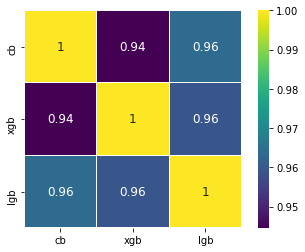

In [89]:
cm = df_all_oof_preds.corr()

sns.heatmap(
    cm,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

### Корреляция результатов на тесте

In [100]:
def predict_by_estimators(test, estimators, test_id=test_id):
    y_pred = np.zeros(test.shape[0])

    for estimator in estimators:
        y_pred += estimator.predict_proba(test)[:, 1]
        
    y_pred = pd.DataFrame({
        "APPLICATION_NUMBER": test_id,
        "TARGET": y_pred / len(estimators)
    })
    return y_pred

In [101]:
cb_test_preds  = predict_by_estimators(test, cb_estimators)
xgb_test_preds = predict_by_estimators(test, xgb_estimators)
lgb_test_preds = predict_by_estimators(test, lgb_estimators)

In [104]:
df_test_preds = pd.DataFrame(np.vstack((cb_test_preds["TARGET"], xgb_test_preds["TARGET"], lgb_test_preds["TARGET"])).T,
                                columns=['cb', 'xgb', 'lgb'])

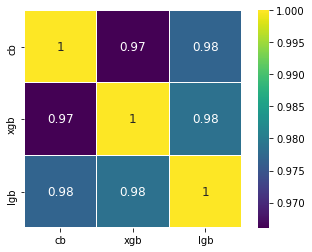

In [106]:
cm = df_test_preds.corr()

sns.heatmap(
    cm,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

#### Усреднение результатов на трейне

In [120]:
df_all_oof_preds["avg"] = df_all_oof_preds[['cb', 'xgb', 'lgb']].mean(axis=1)
df_all_oof_preds["gmean"] = gmean(df_all_oof_preds[['cb', 'xgb', 'lgb']], axis=1)
df_all_oof_preds["rankmean"] = df_all_oof_preds[['cb', 'xgb', 'lgb']].rank().mean(axis=1)

In [121]:
df_all_oof_preds.head(2)

,cb,xgb,lgb,avg,gmean,rankmean
0,0.024803,0.015385,0.017578,0.019256,0.018859,8792.333333
1,0.085755,0.087115,0.086374,0.086415,0.086413,77845.500000


In [127]:
avg_score = roc_auc_score(
    target, df_all_oof_preds["avg"]
)
print(f"Score of combination by AVERAGE: {avg_score}")

Score of combination by AVERAGE: 0.725814114266765


In [128]:
gmean_score = roc_auc_score(
    target, df_all_oof_preds["gmean"]
)
print(f"Score of combination by GEOMETRY MEAN: {gmean_score}")

Score of combination by GEOMETRY MEAN: 0.7257598481495917


In [129]:
rankmean_score = roc_auc_score(
    target, df_all_oof_preds["rankmean"]
)
print(f"Score of combination by RANK MEAN: {rankmean_score}")

Score of combination by RANK MEAN: 0.7256109734143651


Качество примерно такое же, как у моделей по отдельности (чуть лучше у арифметического среднего и чуть хуже у среднего по рангам), но, как я понимаю, засчёт таких усреднений стабильность модели вырастает.

### 5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [130]:
from sklearn.linear_model import LogisticRegression

In [152]:
df_predicts = df_all_oof_preds[['cb', 'xgb', 'lgb']]

In [154]:
x_train, x_test, y_train, y_test = train_test_split(df_predicts, target, test_size=0.3, random_state=42)

In [155]:
lg_regressor = LogisticRegression(random_state=42, solver="liblinear")
lg_regressor.fit(x_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [156]:
lr_score = roc_auc_score(
    y_train, lg_regressor.predict_proba(x_train)[:, 1]
)
print(f"Score of logistic regression on train: {lr_score}")

Score of logistic regression on train: 0.7234777697961352


In [157]:
lr_score = roc_auc_score(
    y_test, lg_regressor.predict_proba(x_test)[:, 1]
)
print(f"Score of logistic regression on valid: {lr_score}")

Score of logistic regression on valid: 0.732995805392715


In [158]:
lr_score = roc_auc_score(
    target, lg_regressor.predict_proba(df_predicts)[:, 1]
)
print(f"Score of logistic regression on all: {lr_score}")

Score of logistic regression on all: 0.7262762681472225


Получился результат ещё лучше, чем по среднему. Среди рассмотренных мной моделей лучший - это бейзлайн на СatИoost, и похоже, что остальные тянут вниз все комбинированные значения, и логистическая регрессия показывает лучший вариант усреднения.